In [1]:
%pip install datasets -q
%pip install accelerate -U -q
%pip install transformers -q
%pip install scikit-learn==1.3.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 21.2 MB/s eta 0:00:00


In [79]:
import urllib
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from datasets import Dataset
import torch
from transformers import (
    BertModel,
    BertTokenizer,
)
import matplotlib.pyplot as plt
import tqdm.notebook as tq
import os
import pickle

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: %s" % device)

Device: cuda


## TASK 1: Corpus


In [4]:
### Argument urls
argument_urls = {
    "train": "https://zenodo.org/records/8248658/files/arguments-training.tsv?download=1",
    "validation": "https://zenodo.org/records/8248658/files/arguments-validation.tsv?download=1",
    "test": "https://zenodo.org/records/8248658/files/arguments-test.tsv?download=1",
}

### Human values urls
level2_values_urls = {
    "train": "https://zenodo.org/records/8248658/files/labels-training.tsv?download=1",
    "validation": "https://zenodo.org/records/8248658/files/labels-validation.tsv?download=1",
    "test": "https://zenodo.org/records/8248658/files/labels-test.tsv?download=1",
}
### Check that the splits in the dict keys were not misspelled
for split in level2_values_urls.keys():
    assert split in argument_urls.keys(), "url dictionary keys misspelled"

In [5]:
### Create Data folder
data_folder = Path.cwd().joinpath("Data")
if not data_folder.exists():
    data_folder.mkdir(parents=True)

### Path for each file
argument_paths = {
    split: data_folder.joinpath(f"arguments_{split}.tsv")
    for split in argument_urls.keys()
}
level2_values_paths = {
    split: data_folder.joinpath(f"labels_{split}.tsv")
    for split in level2_values_urls.keys()
}

### Download each file if it's not already there
for file, path in argument_paths.items():
    if not path.exists():
        urllib.request.urlretrieve(argument_urls[file], filename=path)
for file, path in level2_values_paths.items():
    if not path.exists():
        urllib.request.urlretrieve(level2_values_urls[file], filename=path)

In [6]:
### Read arguments file (split = train/validation/test)
argument_dfs = {
    split: pd.read_csv(path, sep="\t") for split, path in argument_paths.items()
}

### Read human values file (split = train/validation/test)
level2_values_dfs = {
    values_split: pd.read_csv(path, sep="\t")
    for values_split, path in level2_values_paths.items()
}

In [7]:
### Merge arguments and (labels) level 2 values (split = train/validation/test)
args_level2vals_dfs = {
    split: pd.merge(argument, level2_values_dfs[split], on="Argument ID")
    for split, argument in argument_dfs.items()
}

In [8]:
level2_values_dfs["train"].head(2)

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
argument_dfs["train"].head(2)

,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...


In [10]:
args_level2vals_dfs["train"].describe()

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
count,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000
mean,0.183200,0.258669,0.045800,0.031893,0.280363,0.113110,0.115891,0.070833,0.370851,0.320415,0.105322,0.218246,0.038383,0.073243,0.246987,0.149453,0.385871,0.079177,0.123123,0.195439
std,0.386867,0.437944,0.209071,0.175732,0.449218,0.316756,0.320124,0.256569,0.483077,0.466679,0.306996,0.413094,0.192137,0.260559,0.431299,0.356567,0.486845,0.270039,0.328608,0.396575
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
args_level2vals_dfs["train"].head(2)

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
### Considering category ranges (0,3),(3,7),(7,13),(13,19)
### adding +4, considering the first 4 columns which are not categories
level3_categories_ranges = {
    "Openness_to_change": (4, 7),
    "Self_enhancement": (7, 11),
    "Conversation": (11, 17),
    "Self_transcendence": (17, 23),
}
columns_to_keep = ["Argument ID", "Conclusion", "Stance", "Premise"]
level_3_cat = list(level3_categories_ranges.keys())

In [13]:
### Creating final dataframes
train, validation, test = args_level2vals_dfs.keys()
assert train == "train" and validation == "validation" and test == "test"

### nm = not merged
train_df_nm = args_level2vals_dfs["train"]
validation_df_nm = args_level2vals_dfs["validation"]
test_df_nm = args_level2vals_dfs["test"]

### Creating final dataframes
train_df = pd.DataFrame()
validation_df = pd.DataFrame()
test_df = pd.DataFrame()

### Merge lvl2 to lvl 3 (any = OR)
for cat, (start, end) in level3_categories_ranges.items():
    train_df[cat] = train_df_nm.iloc[:, start:end].any(axis=1)
    validation_df[cat] = validation_df_nm.iloc[:, start:end].any(axis=1)
    test_df[cat] = test_df_nm.iloc[:, start:end].any(axis=1)

### Adding the columns to keep of the original dfs
train_df = pd.concat([train_df_nm[columns_to_keep], train_df], axis=1)
validation_df = pd.concat([validation_df_nm[columns_to_keep], validation_df], axis=1)
test_df = pd.concat([test_df_nm[columns_to_keep], test_df], axis=1)

### Define a mapping for "Stance" column
stance_mapping = {"in favor of": 1, "against": 0}

### Apply the mapping to convert strings to boolean values
train_df["Stance"] = train_df["Stance"].map(stance_mapping)
validation_df["Stance"] = validation_df["Stance"].map(stance_mapping)
test_df["Stance"] = test_df["Stance"].map(stance_mapping)

dfs = {"train": train_df, "validation": validation_df, "test": test_df}

In [14]:
train_df["Conversation"].sum()

4018

In [15]:
train_df.head(2)

,Argument ID,Conclusion,Stance,Premise,Openness_to_change,Self_enhancement,Conversation,Self_transcendence
0,A01002,We should ban human cloning,1,we should ban human cloning as it will only ca...,False,False,True,False
1,A01005,We should ban fast food,1,fast food should be banned because it is reall...,False,False,True,False


In [16]:
train_df.describe()

,Stance
count,5393.000000
mean,0.537363
std,0.498648
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


# TASK 2: Model definition

## Baseline Model

In [17]:
def baseline_model(strategy, level_3_cat, train_df, columns_to_keep, seed=None):
    clf_list = [
        DummyClassifier(strategy=strategy, random_state=seed) for _ in level_3_cat
    ]
    [
        clf.fit(X=train_df[columns_to_keep[1:]], y=train_df[cat])
        for clf, cat in zip(clf_list, level_3_cat)
    ]
    return clf_list

## Bert - base Classifier

In [18]:
### Convert dataframes into datasets
datasets = {split: Dataset.from_pandas(df) for split, df in dfs.items()}

In [19]:
def compute_class_weights(df, cat_labels):
    labels_array = df[cat_labels].to_numpy()
    n_ones = np.sum(labels_array, axis=0, dtype=np.single)
    weights = np.empty_like(n_ones)
    n_zeroes = np.array([labels_array.shape[0] - o for o in n_ones])

    for class_num, (ones, zeroes) in enumerate(zip(n_ones, n_zeroes)):
        weights[class_num] = zeroes / (ones + 1e-4)

    print(f"weigts = {weights}")
    return torch.as_tensor(weights, dtype=torch.float).to(device)


def compute_class_weights_root(df, cat_labels):
    labels_array = df[cat_labels].to_numpy()
    n_ones = np.sum(labels_array, axis=0, dtype=np.single)
    weights = np.empty_like(n_ones)
    n_zeroes = np.array([labels_array.shape[0] - o for o in n_ones])

    for class_num, ones in enumerate(n_ones):
        weights[class_num] = np.sqrt(labels_array.shape[0] / (ones + 1e-4))

    print(f"weigts = {weights}")
    return torch.as_tensor(weights, dtype=torch.float).to(device)


def loss_fn(outputs, targets, pos_weight=None):
    return torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)(outputs, targets)

In [20]:
def add_labels(ds_row, labels):
    labels_batch = {k: ds_row[k] for k in ds_row.keys() if k in labels}
    labels_matrix = np.zeros((len(ds_row["Conclusion"]), len(labels)))
    for i, label in enumerate(labels):
        labels_matrix[:, i] = labels_batch[label]
    return labels_matrix.tolist()

### Bert-base Model

In [21]:
class BERTClass(torch.nn.Module):
    def __init__(self, stance=False):
        super().__init__()
        self.bert_model = BertModel.from_pretrained(
            "bert-base-uncased", return_dict=True
        )
        self.dropout = torch.nn.Dropout(0.3)
        if not stance:
            self.linear = torch.nn.Linear(768, len(level_3_cat))
        else:
            ### 769! there is "stance" as another input
            self.linear = torch.nn.Linear(769, len(level_3_cat))

    def forward(self, input_ids, token_type_ids, attn_mask, stance=None):
        output = self.bert_model(
            input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)

        if stance is None:
            output_linear = self.linear(output_dropout)
        else:
            ### concatenate stance
            stance = stance.view(stance.shape[0], -1)
            output_stack = torch.cat((output_dropout, stance), dim=1)
            output_linear = self.linear(output_stack)
        return output_linear

In [22]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
### Encoding
def tokenize(ds_row, tokenizer=tokenizer, premise=False, stance=False):
    ### Tokenize text columns
    if not premise:
        text_tokens = tokenizer(
            ds_row["Conclusion"],
            truncation=True,
            padding="max_length",
            max_length=tokenizer.model_max_length // 2,
            return_tensors="pt",
        )
    else:
        text_tokens = tokenizer(
            ds_row["Conclusion"],
            ds_row["Premise"],
            truncation=True,
            padding="max_length",
            max_length=tokenizer.model_max_length // 2,
            return_tensors="pt",
        )

    ### Combine text tokens with non-text features
    encoded_ds_row = {
        "input_ids": text_tokens["input_ids"],
        "token_type_ids": text_tokens["token_type_ids"],
        "attention_mask": text_tokens["attention_mask"],
    }
    if stance:
        encoded_ds_row.update(
            {
                "Stance": torch.tensor(
                    ds_row["Stance"], dtype=torch.float
                ),  ### Assuming 'Stance' is represented as 0 or 1
            }
        )

    encoded_ds_row["labels"] = add_labels(ds_row, level_3_cat)

    return encoded_ds_row

In [24]:
### Training of the model
def train_model(train_dl, model, optimizer, class_weights, use_stance=False):
    losses = []
    correct_predictions = 0
    num_samples = 0

    ### activate dropout, batch norm
    model.train()

    ### initialize progress bar
    batches = tq.tqdm(
        enumerate(train_dl), total=len(train_dl), leave=True, colour="steelblue"
    )

    for batch_idx, data in batches:
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)
        if use_stance:
            stance = data["Stance"].to(device, dtype=torch.float)
            outputs = model(ids, token_type_ids, mask, stance)  ### Forward
        else:
            outputs = model(ids, token_type_ids, mask)  ### Forward

        loss = loss_fn(outputs, labels, class_weights)
        losses.append(loss.cpu().detach().numpy())

        ### apply thresh 0.5
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        labels = labels.cpu().detach().numpy()
        correct_predictions += np.sum(outputs == labels)
        num_samples += labels.size

        ### Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        ### Grad descent step
        optimizer.step()

        ### Update progress bar
        batches.set_description(f"")
        batches.set_postfix(batch_loss=loss)

    accuracy = float(correct_predictions) / num_samples
    return model, accuracy, losses

# Task 3: Metrics

### Baseline Metric

In [25]:
def f1_baseline(prediction, labels, data):
    ### Evaluate F1 overall
    f1_overall = f1_score(
        y_true=data[labels], y_pred=prediction, average="macro", zero_division=np.nan
    )

    ### Evaluate F1 per category
    f1_per_cat = [
        f1_score(y_true=data[cat], y_pred=prediction[:, i])
        for i, cat in enumerate(labels)
    ]

    return f1_overall, f1_per_cat

### Bert base model metric

In [26]:
def eval_model(validation_dl, model, class_weights, use_stance=False):
    losses = []
    correct_predictions = 0
    num_samples = 0
    num_categories = next(iter(validation_dl))["labels"].shape[1]

    ### accumulate data over each batch to compute the f1
    true_positives = np.array([0 for _ in range(num_categories)])
    false_positives = np.array([0 for _ in range(num_categories)])
    false_negatives = np.array([0 for _ in range(num_categories)])

    ### turn off dropout, fix batch norm
    model.eval()

    ### show progress bar
    batches = tq.tqdm(
        enumerate(validation_dl),
        total=len(validation_dl),
        leave=True,
        colour="steelblue",
    )
    # batches = enumerate(validation_dl)
    with torch.no_grad():
        for batch_idx, data in batches:
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)
            if use_stance:
                stance = data["Stance"].to(device, dtype=torch.float)
                outputs = model(ids, token_type_ids, mask, stance)  ### Forward
            else:
                outputs = model(ids, token_type_ids, mask)

            loss = loss_fn(outputs, labels, class_weights)
            losses.append(loss.cpu().detach().numpy())

            ### validation accuracy
            ### training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            labels = labels.cpu().detach().numpy()
            correct_predictions += np.sum(outputs == labels)
            num_samples += labels.size

            ### TP: predicttion == 1, true label == 1
            true_positives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 1, labels[:, i] == 1))
                    for i in range(num_categories)
                ]
            )

            ### FP: prediction == 1, true label == 0
            false_positives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 1, labels[:, i] == 0))
                    for i in range(num_categories)
                ]
            )

            ### FN: prediction == 0, true label == 1
            false_negatives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 0, labels[:, i] == 1))
                    for i in range(num_categories)
                ]
            )

        accuracy = float(correct_predictions) / num_samples
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_per_cat = 2 * (precision * recall) / (precision + recall)
        f1_overall = np.mean(f1_per_cat)
    return accuracy, losses, f1_overall, f1_per_cat

In [27]:
def save_item(item, name):
    if not os.path.isdir("results"):
        os.mkdir("results")
    with open(f"results/{name}.pickle", "wb") as bf:
        pickle.dump(item, bf)


def read_item(name):
    item = None
    with open(f"results/{name}.pickle", "rb") as bf:
        item = pickle.load(bf)
    return item

# TASK 4 - Training and Evaluation

## Baseline

In [28]:
### Random uniform classifier

seeds = [333, 666, 999]
history_list_uniform = []
for seed in seeds:
    model_uniform = baseline_model(
        "uniform", level_3_cat, train_df, columns_to_keep, seed
    )

    prediction_uniform = np.array(
        [clf.predict(X=validation_df[columns_to_keep[1:]]) for clf in model_uniform]
    ).T

    f1_overall, f1_percat = f1_baseline(
        prediction_uniform, labels=level_3_cat, data=validation_df
    )

    history_list_uniform.append([f1_overall, f1_percat])

In [29]:
save_item(history_list_uniform, "baseline_uniform")
print("Random uniform classifier:")
for h, s in zip(history_list_uniform, seeds):
    print(f"SEED = {s}")
    print(f"f1_overall = {h[0]}  f1_per_cat = {h[1]}")

Random uniform classifier:
SEED = 333
f1_overall = 0.5124357057924442  f1_per_cat = [0.4307692307692307, 0.44218838127467563, 0.5909863945578232, 0.5857988165680473]
SEED = 666
f1_overall = 0.5211104928753427  f1_per_cat = [0.42398022249690986, 0.4597961494903737, 0.5978678038379531, 0.6027977956761339]
SEED = 999
f1_overall = 0.5228458181625661  f1_per_cat = [0.427255985267035, 0.45807540799099605, 0.5959252971137522, 0.610126582278481]


In [30]:
### Majority classifier

prediction_majority = baseline_model(
    "most_frequent", level_3_cat, train_df, columns_to_keep
)

prediction_majority = np.array(
    [clf.predict(X=validation_df[columns_to_keep[1:]]) for clf in model_uniform]
).T

f1_overall, f1_percat = f1_baseline(
    prediction_majority, labels=level_3_cat, data=validation_df
)

history_majority = (f1_overall, f1_percat)

In [31]:
save_item(history_majority, "baseline_majority")
print("Majority classifier:")
print(f"SEED = {s}")
print(f"f1_overall = {history_majority[0]}  f1_per_cat = {history_majority[1]}")

Majority classifier:
SEED = 999
f1_overall = 0.5228458181625661  f1_per_cat = [0.427255985267035, 0.45807540799099605, 0.5959252971137522, 0.610126582278481]


## Bert-base models

In [32]:
def create_data_loaders(tokenized_datasets, batch_size):
    train_dl = torch.utils.data.DataLoader(
        tokenized_datasets["train"],
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
    )

    validation_dl = torch.utils.data.DataLoader(
        tokenized_datasets["validation"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )

    test_dl = torch.utils.data.DataLoader(
        tokenized_datasets["test"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )
    return train_dl, validation_dl, test_dl

In [33]:
def setup(
    datasets,
    learning_rate,
    batch_size=32,
    weight_decay=0.01,
    premise=False,
    stance=False,
    ### from here on there is no need to specify the arguments
    tokenization_function=tokenize,
    tokenizer=tokenizer,
    model_class=BERTClass,
):
    ### tokenize each ds in the datasets dictionary
    ### mapping the tokenization function on each dataset
    tokenized_datasets = {
        split: ds.map(
            function=tokenization_function,
            fn_kwargs={"tokenizer": tokenizer, "premise": premise, "stance": stance},
            batched=True,
            remove_columns=[
                "Argument ID",
                "Conclusion",
                "Stance",
                "Premise",
                "Openness_to_change",
                "Self_enhancement",
                "Conversation",
                "Self_transcendence",
            ],
        )
        for split, ds in datasets.items()
    }

    for ds in tokenized_datasets.values():
        ds.set_format(type="torch")

    train_dl, validation_dl, test_dl = create_data_loaders(
        tokenized_datasets, batch_size
    )

    ### define the model
    model = model_class(stance=stance)

    model.to(device)

    ### define the optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    return (train_dl, validation_dl, test_dl), model, optimizer

In [34]:
def train_eval(
    dls,
    model,
    optimizer,
    class_weights,
    n_epochs=1,
    save_name="0",
    use_stance=False,
    ### from here on there is no need to specify the arguments
    train_model_f=train_model,
    eval_model_f=eval_model,
):
    model_folder = Path.cwd().joinpath("models")
    if not model_folder.exists():
        model_folder.mkdir(parents=True)

    history = {}
    best_f1 = 0
    train_dl, validation_dl, test_dl = dls

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}/{n_epochs}")
        model, train_acc, train_losses = train_model_f(
            train_dl, model, optimizer, class_weights, use_stance
        )
        val_acc, val_losses, f1_overall, f1_per_cat = eval_model_f(
            validation_dl, model, class_weights, use_stance
        )

        print(
            f"train_loss={np.mean(train_losses):.4f}, val_loss={np.mean(val_losses):.4f}, ",
            f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, ",
            f"val_f1_overall={f1_overall:.4f}, " f"val_f1_per_cat={f1_per_cat}",
        )

        history.update({"train_acc": train_acc})
        history.update({"train_losses": train_losses})
        history.update({"val_acc": val_acc})
        history.update({"val_losses": val_losses})
        history.update({"f1_overall": f1_overall})
        history.update({"f1_per_cat": f1_per_cat})

        ### save the best model
        if f1_overall > best_f1:
            torch.save(
                model.state_dict(),
                Path.joinpath(model_folder, f"model_{save_name}.bin"),
            )
            best_f1 = f1_overall

    return (history["f1_overall"], history["f1_per_cat"], history["train_losses"])

In [35]:
### Generic Parameters
BATCH_SIZE = 32
N_EPOCHS = 1
LEARNING_RATE_3 = 3e-5
LEARNING_RATE_2 = 2e-5
WEIGHT_DECAY = 0.01

seeds = [333, 666, 999]
# seeds = [333, 666]
# class_weights = compute_class_weights(train_df, level_3_cat)
class_weights = compute_class_weights_root(train_df, level_3_cat)

plot_loss = True

weigts = [1.6664435 1.5299385 1.1585379 1.1881835]


### Bert Conclusion-Only  1 epoch



In [36]:
LEARNING_RATE_Co = LEARNING_RATE_3

### loop over seeds:
history_list_c_lr3 = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_c, optimizer_c = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_Co,
        weight_decay=WEIGHT_DECAY,
        premise=False,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_c,
        optimizer=optimizer_c,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_{seed_idx}",
        use_stance=False,
    )
    history_list_c_lr3.append(history)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7122, val_loss=0.7223,  train_acc=0.6624, val_acc=0.6829,  val_f1_overall=0.6571, val_f1_per_cat=[0.30408163 0.6223812  0.84846644 0.8533414 ]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7055, val_loss=0.7187,  train_acc=0.6716, val_acc=0.6850,  val_f1_overall=0.6625, val_f1_per_cat=[0.31211499 0.6359584  0.84846644 0.8533414 ]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7118, val_loss=0.7376,  train_acc=0.6608, val_acc=0.6696,  val_f1_overall=0.6122, val_f1_per_cat=[0.15482234 0.59199237 0.84846644 0.8533414 ]


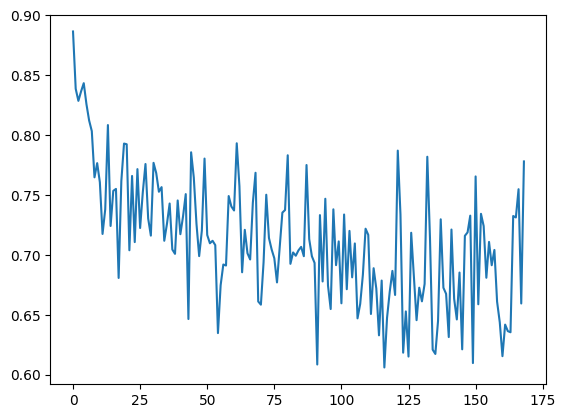

In [37]:
if plot_loss:
    plt.plot(history_list_c_lr3[0][2])

In [38]:
LEARNING_RATE_Co = LEARNING_RATE_2

### loop over seeds:
history_list_c_lr2 = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_c, optimizer_c = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_Co,
        weight_decay=WEIGHT_DECAY,
        premise=False,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_c,
        optimizer=optimizer_c,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_{seed_idx}",
        use_stance=False,
    )
    history_list_c_lr2.append(history)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7109, val_loss=0.7194,  train_acc=0.6616, val_acc=0.6770,  val_f1_overall=0.6470, val_f1_per_cat=[0.30408163 0.58208955 0.84846644 0.8533414 ]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7096, val_loss=0.7160,  train_acc=0.6669, val_acc=0.6816,  val_f1_overall=0.6620, val_f1_per_cat=[0.34275296 0.60335196 0.84846644 0.8533414 ]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7186, val_loss=0.7375,  train_acc=0.6549, val_acc=0.6785,  val_f1_overall=0.6093, val_f1_per_cat=[0.13333333 0.6021164  0.84846644 0.8533414 ]


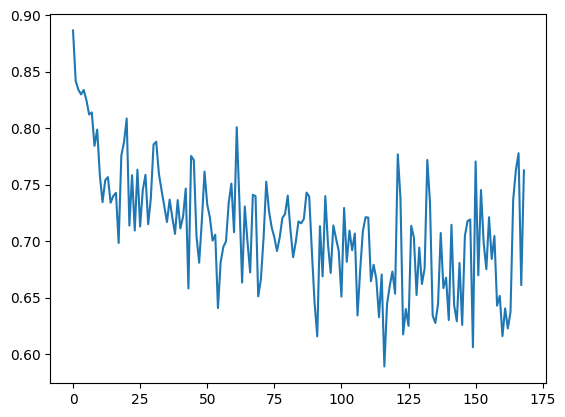

In [39]:
if plot_loss:
    plt.plot(history_list_c_lr2[0][2])

### Bert with Conclusion and Premise 1 epoch

In [40]:
LEARNING_RATE_CP = LEARNING_RATE_3

### loop over seeds:
history_list_cp_lr3 = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cp, optimizer_cp = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CP,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_cp,
        optimizer=optimizer_cp,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_premise_{seed_idx}",
        use_stance=False,
    )
    history_list_cp_lr3.append(history)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6718, val_loss=0.6439,  train_acc=0.6939, val_acc=0.7068,  val_f1_overall=0.7456, val_f1_per_cat=[0.59901599 0.68266667 0.85099846 0.84963325]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6720, val_loss=0.6336,  train_acc=0.6984, val_acc=0.7276,  val_f1_overall=0.7499, val_f1_per_cat=[0.61505376 0.68189415 0.85555898 0.84694836]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6740, val_loss=0.6436,  train_acc=0.6944, val_acc=0.7078,  val_f1_overall=0.7410, val_f1_per_cat=[0.58234885 0.67361111 0.85285101 0.85514728]


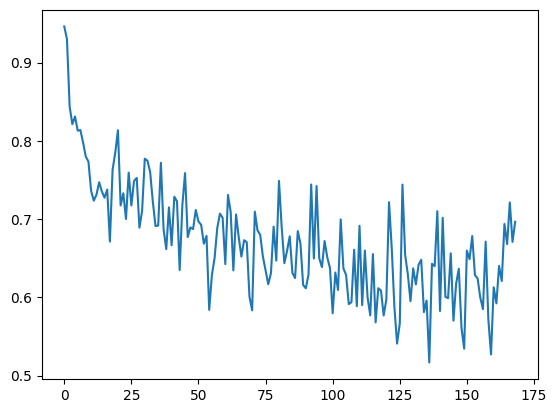

In [41]:
if plot_loss:
    plt.plot(history_list_cp_lr3[0][2])

In [42]:
LEARNING_RATE_CP = LEARNING_RATE_2

### loop over seeds:
history_list_cp_lr2 = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cp, optimizer_cp = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CP,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_cp,
        optimizer=optimizer_cp,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_premise_{seed_idx}",
        use_stance=False,
    )
    history_list_cp_lr2.append(history)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6895, val_loss=0.6552,  train_acc=0.6787, val_acc=0.7139,  val_f1_overall=0.7314, val_f1_per_cat=[0.54244929 0.68019748 0.84974093 0.8533414 ]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6812, val_loss=0.6421,  train_acc=0.6897, val_acc=0.7184,  val_f1_overall=0.7468, val_f1_per_cat=[0.60822657 0.67699115 0.8531941  0.84863371]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6891, val_loss=0.6484,  train_acc=0.6831, val_acc=0.7149,  val_f1_overall=0.7367, val_f1_per_cat=[0.56798867 0.67572156 0.84966525 0.8533414 ]


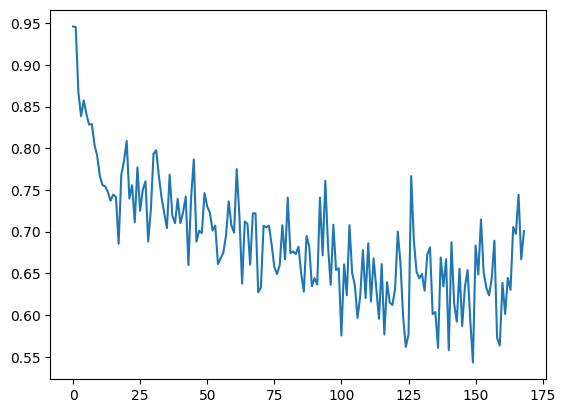

In [43]:
if plot_loss:
    plt.plot(history_list_cp_lr2[0][2])

### Bert with Conclusion Premise and Stance 1 epoch:

In [44]:
LEARNING_RATE_CPS = LEARNING_RATE_3

### loop over seeds:
history_list_cps_lr3 = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cps, optimizer_cps = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CPS,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=True,
    )

    history = train_eval(
        dls=dls,
        model=model_cps,
        optimizer=optimizer_cps,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_premise_stance{seed_idx}",
        use_stance=True,
    )
    history_list_cps_lr3.append(history)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6747, val_loss=0.6559,  train_acc=0.6948, val_acc=0.7238,  val_f1_overall=0.7287, val_f1_per_cat=[0.53654342 0.67567568 0.84931507 0.85316379]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6726, val_loss=0.6356,  train_acc=0.6931, val_acc=0.7235,  val_f1_overall=0.7407, val_f1_per_cat=[0.56896552 0.68855932 0.85423729 0.85119412]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6704, val_loss=0.6357,  train_acc=0.6952, val_acc=0.7267,  val_f1_overall=0.7406, val_f1_per_cat=[0.58848614 0.66830769 0.85180573 0.85382972]


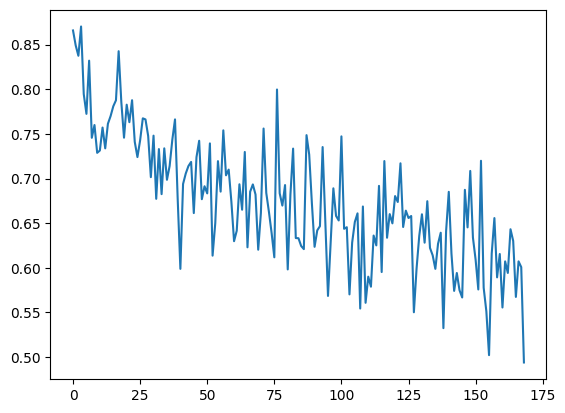

In [45]:
if plot_loss:
    plt.plot(history_list_cps_lr3[0][2])

In [46]:
LEARNING_RATE_CPS = LEARNING_RATE_2

### loop over seeds:
history_list_cps_lr2 = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cps, optimizer_cps = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CPS,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=True,
    )

    history = train_eval(
        dls=dls,
        model=model_cps,
        optimizer=optimizer_cps,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_premise_stance{seed_idx}",
        use_stance=True,
    )
    history_list_cps_lr2.append(history)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6872, val_loss=0.6647,  train_acc=0.6862, val_acc=0.7148,  val_f1_overall=0.7243, val_f1_per_cat=[0.52622814 0.66846944 0.8490566  0.8533414 ]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6897, val_loss=0.6500,  train_acc=0.6794, val_acc=0.7197,  val_f1_overall=0.7283, val_f1_per_cat=[0.53873239 0.6725756  0.85215794 0.84980116]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/1


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6876, val_loss=0.6665,  train_acc=0.6840, val_acc=0.7260,  val_f1_overall=0.7124, val_f1_per_cat=[0.54470199 0.60043197 0.85053272 0.85402786]


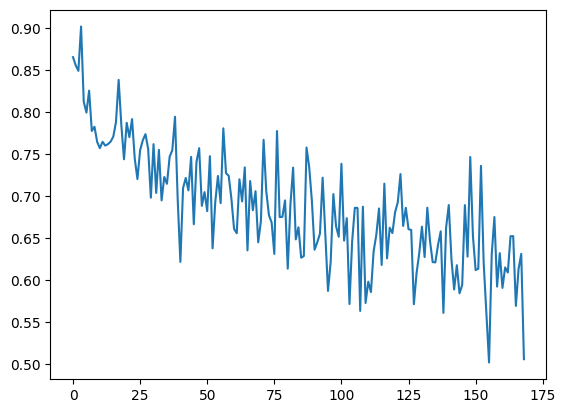

In [47]:
if plot_loss:
    plt.plot(history_list_cps_lr2[0][2])

In [48]:
print("Results for 1 epoch of training")
for hl, name in zip(
    (
        history_list_c_lr3,
        history_list_c_lr2,
        history_list_cp_lr3,
        history_list_cp_lr2,
        history_list_cps_lr3,
        history_list_cps_lr2,
    ),
    ("C_lr3", "C_lr2", "CP_lr3", "CP_lr2", "CPS_lr3", "CPS_lr2"),
):
    save_item(hl, name)
    print(name)
    for h, s in zip(hl, seeds):
        print(f"SEED = {s}")
        print(f"F1 overall = {h[0]:.4f}")
        print(f"F1 per cat = {[ f'{i:.4f}' for i in h[1] ]}\n")

Results for 1 epoch of training
C_lr3
SEED = 333
F1 overall = 0.6571
F1 per cat = ['0.3041', '0.6224', '0.8485', '0.8533']

SEED = 666
F1 overall = 0.6625
F1 per cat = ['0.3121', '0.6360', '0.8485', '0.8533']

SEED = 999
F1 overall = 0.6122
F1 per cat = ['0.1548', '0.5920', '0.8485', '0.8533']

C_lr2
SEED = 333
F1 overall = 0.6470
F1 per cat = ['0.3041', '0.5821', '0.8485', '0.8533']

SEED = 666
F1 overall = 0.6620
F1 per cat = ['0.3428', '0.6034', '0.8485', '0.8533']

SEED = 999
F1 overall = 0.6093
F1 per cat = ['0.1333', '0.6021', '0.8485', '0.8533']

CP_lr3
SEED = 333
F1 overall = 0.7456
F1 per cat = ['0.5990', '0.6827', '0.8510', '0.8496']

SEED = 666
F1 overall = 0.7499
F1 per cat = ['0.6151', '0.6819', '0.8556', '0.8469']

SEED = 999
F1 overall = 0.7410
F1 per cat = ['0.5823', '0.6736', '0.8529', '0.8551']

CP_lr2
SEED = 333
F1 overall = 0.7314
F1 per cat = ['0.5424', '0.6802', '0.8497', '0.8533']

SEED = 666
F1 overall = 0.7468
F1 per cat = ['0.6082', '0.6770', '0.8532', '0.8486

### Bert Conclusion-Only  2 epochs



Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7255, val_loss=0.7224,  train_acc=0.6461, val_acc=0.6593,  val_f1_overall=0.6607, val_f1_per_cat=[0.40461538 0.53647587 0.84846644 0.8533414 ]
Epoch 2/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6779, val_loss=0.7142,  train_acc=0.6957, val_acc=0.6475,  val_f1_overall=0.6896, val_f1_per_cat=[0.51922006 0.537514   0.84846644 0.8533414 ]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7223, val_loss=0.7242,  train_acc=0.6542, val_acc=0.6208,  val_f1_overall=0.6628, val_f1_per_cat=[0.40085288 0.54842876 0.84846644 0.8533414 ]
Epoch 2/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6827, val_loss=0.7262,  train_acc=0.6944, val_acc=0.6631,  val_f1_overall=0.6325, val_f1_per_cat=[0.2568306  0.57126633 0.84846644 0.8533414 ]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7328, val_loss=0.7277,  train_acc=0.6411, val_acc=0.6614,  val_f1_overall=0.6432, val_f1_per_cat=[0.29583702 0.57512116 0.84846644 0.8533414 ]
Epoch 2/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6869, val_loss=0.7328,  train_acc=0.6940, val_acc=0.6246,  val_f1_overall=0.6733, val_f1_per_cat=[0.42140921 0.57008948 0.84846644 0.8533414 ]


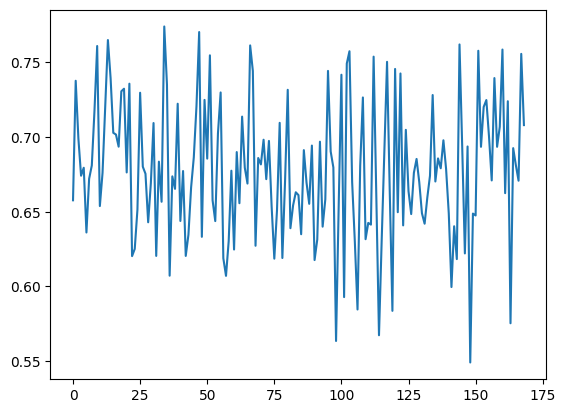

In [49]:
### loop over seeds:
history_list_c_2e = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_c, optimizer_c = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_Co / 2,
        weight_decay=WEIGHT_DECAY,
        premise=False,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_c,
        optimizer=optimizer_c,
        class_weights=class_weights,
        n_epochs=N_EPOCHS * 2,
        save_name=f"conclusion_{seed_idx}",
        use_stance=False,
    )
    history_list_c_2e.append(history)
plt.plot(history_list_c_2e[0][2])

### Bert with Conclusion and Premise 2 epoch

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7152, val_loss=0.6812,  train_acc=0.6566, val_acc=0.7032,  val_f1_overall=0.7120, val_f1_per_cat=[0.4792176  0.66561014 0.84975669 0.8533414 ]
Epoch 2/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6210, val_loss=0.6548,  train_acc=0.7369, val_acc=0.7231,  val_f1_overall=0.7306, val_f1_per_cat=[0.55851852 0.65945258 0.8516129  0.85299456]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7109, val_loss=0.6731,  train_acc=0.6646, val_acc=0.7094,  val_f1_overall=0.7285, val_f1_per_cat=[0.57006803 0.64087062 0.84964928 0.8533414 ]
Epoch 2/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6175, val_loss=0.6491,  train_acc=0.7383, val_acc=0.7282,  val_f1_overall=0.7276, val_f1_per_cat=[0.54188034 0.66423801 0.85138847 0.85307483]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7186, val_loss=0.6779,  train_acc=0.6605, val_acc=0.7045,  val_f1_overall=0.7062, val_f1_per_cat=[0.4845679  0.63730887 0.84924012 0.85359952]
Epoch 2/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6226, val_loss=0.6431,  train_acc=0.7343, val_acc=0.7169,  val_f1_overall=0.7444, val_f1_per_cat=[0.60446247 0.66741196 0.85155773 0.85402124]


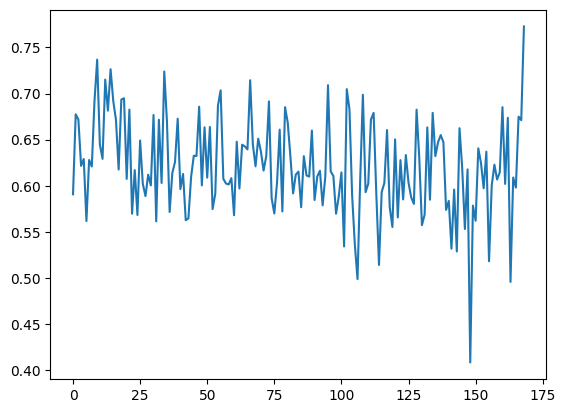

In [50]:
### loop over seeds:
history_list_cp_2e = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cp, optimizer_cp = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CP / 2,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_cp,
        optimizer=optimizer_cp,
        class_weights=class_weights,
        n_epochs=N_EPOCHS * 2,
        save_name=f"conclusion_premise_{seed_idx}",
        use_stance=False,
    )
    history_list_cp_2e.append(history)
plt.plot(history_list_cp_2e[0][2])

### Bert with Conclusion Premise and Stance 2 epoch:

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7100, val_loss=0.6755,  train_acc=0.6704, val_acc=0.6929,  val_f1_overall=0.7219, val_f1_per_cat=[0.54225828 0.64358018 0.84826325 0.8533414 ]
Epoch 2/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6223, val_loss=0.6565,  train_acc=0.7376, val_acc=0.7085,  val_f1_overall=0.7325, val_f1_per_cat=[0.56515775 0.6603032  0.85120684 0.8533414 ]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7178, val_loss=0.6798,  train_acc=0.6513, val_acc=0.7151,  val_f1_overall=0.6938, val_f1_per_cat=[0.40973631 0.66441441 0.84844796 0.85262838]
Epoch 2/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6164, val_loss=0.6382,  train_acc=0.7382, val_acc=0.7268,  val_f1_overall=0.7355, val_f1_per_cat=[0.56200942 0.67407841 0.85503232 0.85101165]


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Epoch 1/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.7152, val_loss=0.6787,  train_acc=0.6613, val_acc=0.7049,  val_f1_overall=0.7109, val_f1_per_cat=[0.52559206 0.61650485 0.84846644 0.85299456]
Epoch 2/2


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

train_loss=0.6187, val_loss=0.6481,  train_acc=0.7377, val_acc=0.7209,  val_f1_overall=0.7348, val_f1_per_cat=[0.57164869 0.66360505 0.85044167 0.85342217]


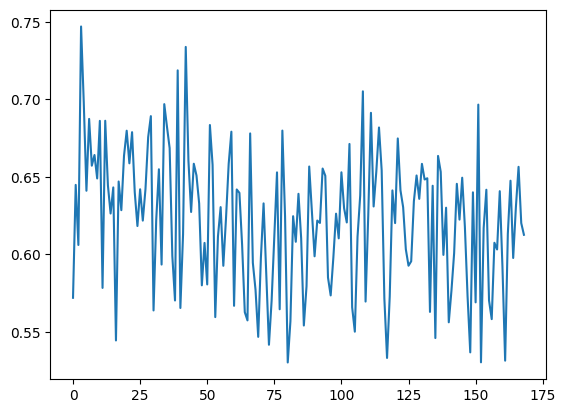

In [51]:
### loop over seeds:
history_list_cps_2e = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cps, optimizer_cps = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CPS / 2,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=True,
    )

    history = train_eval(
        dls=dls,
        model=model_cps,
        optimizer=optimizer_cps,
        class_weights=class_weights,
        n_epochs=N_EPOCHS * 2,
        save_name=f"conclusion_premise_stance{seed_idx}",
        use_stance=True,
    )
    history_list_cps_2e.append(history)
plt.plot(history_list_cps_2e[0][2])

In [52]:
print("Results for 2 epochs of training")
for hl, name in zip(
    (
        history_list_c_2e,
        history_list_cp_2e,
        history_list_cps_2e,
    ),
    ("C_2e", "CP_2e", "CPS_2e"),
):
    save_item(hl, name)
    print(name)
    for h, s in zip(hl, seeds):
        print(f"SEED = {s}")
        print(f"F1 overall = {h[0]:.4f}")
        print(f"F1 per cat = {[ f'{i:.4f}' for i in h[1] ]}\n")

Results for 2 epochs of training
C_2e
SEED = 333
F1 overall = 0.6896
F1 per cat = ['0.5192', '0.5375', '0.8485', '0.8533']

SEED = 666
F1 overall = 0.6325
F1 per cat = ['0.2568', '0.5713', '0.8485', '0.8533']

SEED = 999
F1 overall = 0.6733
F1 per cat = ['0.4214', '0.5701', '0.8485', '0.8533']

CP_2e
SEED = 333
F1 overall = 0.7306
F1 per cat = ['0.5585', '0.6595', '0.8516', '0.8530']

SEED = 666
F1 overall = 0.7276
F1 per cat = ['0.5419', '0.6642', '0.8514', '0.8531']

SEED = 999
F1 overall = 0.7444
F1 per cat = ['0.6045', '0.6674', '0.8516', '0.8540']

CPS_2e
SEED = 333
F1 overall = 0.7325
F1 per cat = ['0.5652', '0.6603', '0.8512', '0.8533']

SEED = 666
F1 overall = 0.7355
F1 per cat = ['0.5620', '0.6741', '0.8550', '0.8510']

SEED = 999
F1 overall = 0.7348
F1 per cat = ['0.5716', '0.6636', '0.8504', '0.8534']



# Task 5: Error Analysis

In [83]:
def avg_hist(hists):
    overall = np.average([hist[0] for hist in hists])
    per_cat = [np.average([hist[1][i] for hist in hists]) for i in range(4)]
    return [overall] + per_cat


def std_hist(hists):
    overall = np.std([hist[0] for hist in hists])
    per_cat = [np.std([hist[1][i] for hist in hists]) for i in range(4)]
    return [overall] + per_cat

In [77]:
READ_DATA = True

if READ_DATA:
    history_list_c_lr3 = read_item("C_lr3")
    history_list_cp_lr3 = read_item("CP_lr3")
    history_list_cps_lr3 = read_item("CPS_lr3")

    history_list_c_lr2 = read_item("C_lr2")
    history_list_cp_lr2 = read_item("CP_lr2")
    history_list_cps_lr2 = read_item("CPS_lr2")

    history_list_c_2e = read_item("C_2e")
    history_list_cp_2e = read_item("CP_2e")
    history_list_cps_2e = read_item("CPS_2e")

    history_list_uniform = read_item("baseline_uniform")
    history_majority = read_item("baseline_majority")

In [84]:
### class frequencies of the train set:
labels_array = train_df[level_3_cat].to_numpy()
class_frequencies = (
    np.sum(labels_array, axis=0, dtype=np.single) / labels_array.shape[0]
)
class_frequencies = np.concatenate([np.zeros(1), class_frequencies], axis=None)

### Compute avg, std over the random seeds
avg_f1_c_lr3 = avg_hist(history_list_c_lr3)
avg_f1_cp_lr3 = avg_hist(history_list_cp_lr3)
avg_f1_cps_lr3 = avg_hist(history_list_cps_lr3)

avg_f1_c_lr2 = avg_hist(history_list_c_lr2)
avg_f1_cp_lr2 = avg_hist(history_list_cp_lr2)
avg_f1_cps_lr2 = avg_hist(history_list_cps_lr2)

avg_f1_uniform = avg_hist(history_list_uniform)
avg_f1_majority = [history_majority[0]] + history_majority[1]

avg_f1_c_2e = avg_hist(history_list_c_2e)
avg_f1_cp_2e = avg_hist(history_list_cp_2e)
avg_f1_cps_2e = avg_hist(history_list_cps_2e)

### TODO use this
std_f1_c_lr3 = std_hist(history_list_c_lr3)
std_f1_cp_lr3 = std_hist(history_list_cp_lr3)
std_f1_cps_lr3 = std_hist(history_list_cps_lr3)

std_f1_c_lr2 = std_hist(history_list_c_lr2)
std_f1_cp_lr2 = std_hist(history_list_cp_lr2)
std_f1_cps_lr2 = std_hist(history_list_cps_lr2)

std_f1_c_2e = std_hist(history_list_c_2e)
std_f1_cp_2e = std_hist(history_list_cp_2e)
std_f1_cps_2e = std_hist(history_list_cps_2e)

In [85]:
title_font = {
    "size": 16,
    "weight": "bold",
}
axis_font = {
    "size": 11,
}
legend_title_font = {"weight": "bold"}

### STD of f1 score of bert models trained for 2 epochs

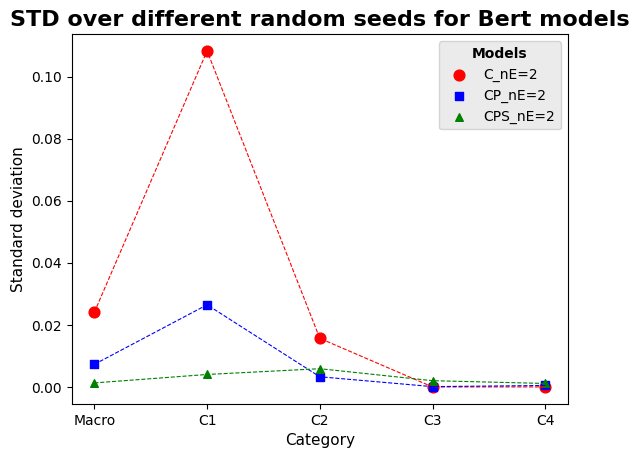

In [123]:
### Plot: variance over random seeds for Bert Models

std_devs = (
    std_f1_c_2e,
    std_f1_cp_2e,
    std_f1_cps_2e,
)
color_list = ["red", "blue", "green"]
marker_list = ["o", "s", "^"]
label_list = [
    "C_nE=2",
    "CP_nE=2",
    "CPS_nE=2",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("STD over different random seeds for Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
markersize = np.array([60, 40, 30])
# plt.yscale("log")

for s, color, label, marker, ms in zip(
    std_devs, color_list, label_list, marker_list, markersize
):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker, s=ms)
    plt.plot(range(len(s)), s, color=color, linewidth=0.8, linestyle="--")
plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    # ncols=3,
)

### STD of f1 score of bert models trained with LR = 3e-5

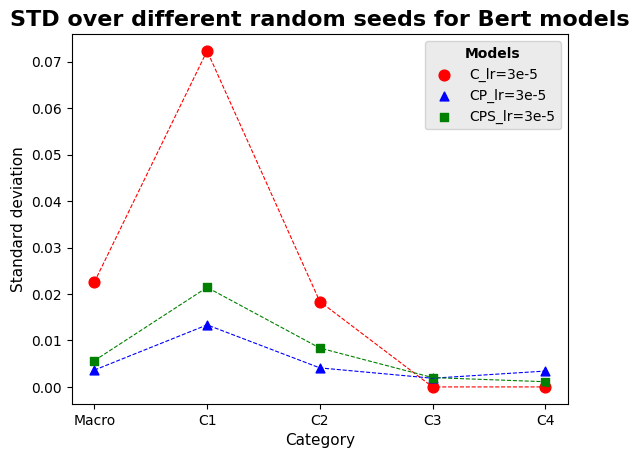

In [124]:
### Plot: variance over random seeds for Bert Models
std_devs = (
    std_f1_c_lr3,
    std_f1_cp_lr3,
    std_f1_cps_lr3,
)
color_list = ["red", "blue", "green"]
marker_list = ["o", "^", "s"]
label_list = [
    "C_lr=3e-5",
    "CP_lr=3e-5",
    "CPS_lr=3e-5",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("STD over different random seeds for Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
markersize = np.array([60, 40, 30])
# plt.yscale("log")

for s, color, label, marker, ms in zip(
    std_devs, color_list, label_list, marker_list, markersize
):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker, s=ms)
    plt.plot(range(len(s)), s, color=color, linewidth=0.8, linestyle="--")
plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    # ncols=3,
    # loc="lower center",
)

### STD of f1 score of bert models trained with LR = 3e-5

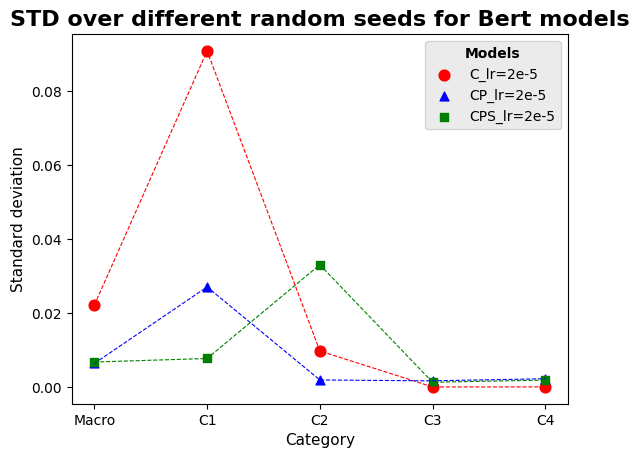

In [125]:
### Plot: variance over random seeds for Bert Models

std_devs = (
    std_f1_c_lr2,
    std_f1_cp_lr2,
    std_f1_cps_lr2,
)
color_list = ["red", "blue", "green"]
marker_list = ["o", "^", "s"]
label_list = [
    "C_lr=2e-5",
    "CP_lr=2e-5",
    "CPS_lr=2e-5",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("STD over different random seeds for Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
markersize = np.array([60, 40, 30])
# plt.yscale("log")

for s, color, label, marker, ms in zip(
    std_devs, color_list, label_list, marker_list, markersize
):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker, s=ms)
    plt.plot(range(len(s)), s, color=color, linewidth=0.8, linestyle="--")
plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    # ncols=3,
)

### f1 score of baseline and bert models trained with LR = 3e-5

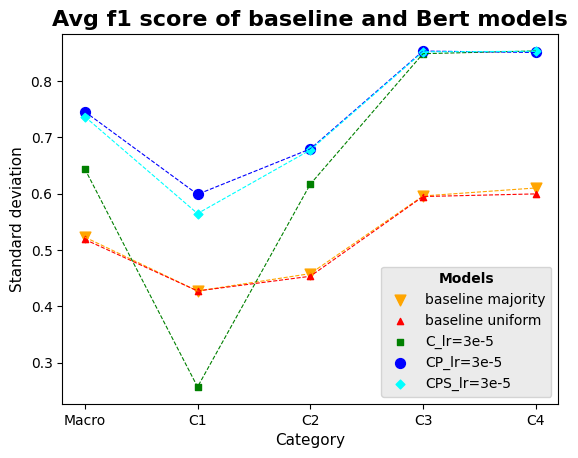

In [126]:
### Plot: f1 score bert vs baseline: overall

f1s = (avg_f1_majority, avg_f1_uniform, avg_f1_c_lr3, avg_f1_cp_lr3, avg_f1_cps_lr3)
color_list = ["orange", "red", "green", "blue", "aqua"]
marker_list = ["v", "^", "s", "o", "D"]
label_list = [
    "baseline majority",
    "baseline uniform",
    "C_lr=3e-5",
    "CP_lr=3e-5",
    "CPS_lr=3e-5",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("Avg f1 score of baseline and Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
markersize = np.array([60, 20, 20, 50, 20])
# plt.yscale("log")

for s, color, label, marker, ms in zip(
    f1s, color_list, label_list, marker_list, markersize
):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker, s=ms)
    plt.plot(range(len(s)), s, color=color, linewidth=0.8, linestyle="--")
plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    # ncols=3,
)

### f1 score of baseline and bert models trained with LR = 2e-5

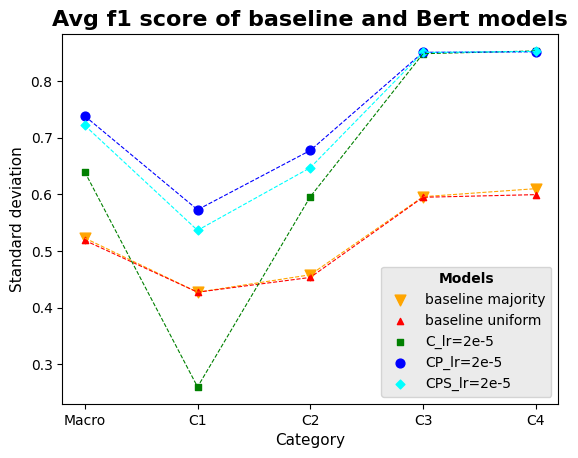

In [127]:
### Plot: f1 score bert vs baseline: overall

f1s = (avg_f1_majority, avg_f1_uniform, avg_f1_c_lr2, avg_f1_cp_lr2, avg_f1_cps_lr2)
color_list = ["orange", "red", "green", "blue", "aqua"]
marker_list = ["v", "^", "s", "o", "D"]
label_list = [
    "baseline majority",
    "baseline uniform",
    "C_lr=2e-5",
    "CP_lr=2e-5",
    "CPS_lr=2e-5",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("Avg f1 score of baseline and Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
markersize = np.array([60, 20, 20, 40, 20])
# plt.yscale("log")

for s, color, label, marker, ms in zip(
    f1s, color_list, label_list, marker_list, markersize
):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker, s=ms)
    plt.plot(range(len(s)), s, color=color, linewidth=0.8, linestyle="--")
plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    # ncols=3,
)

### f1 score and class frequencies for baseline and bert models with LR=3e-5

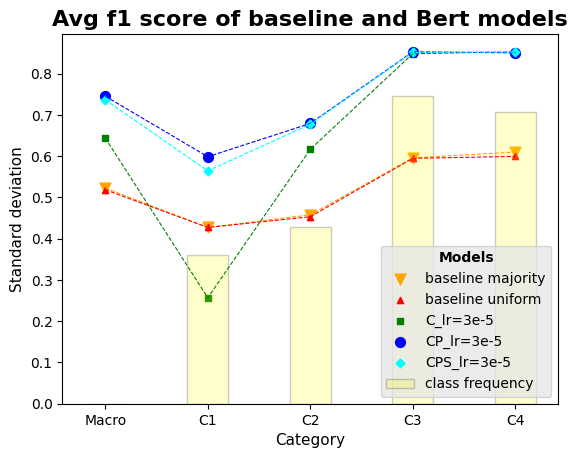

In [128]:
### Plot: class frequency(column) vs f1 score per model (scatter)

f1s = (avg_f1_majority, avg_f1_uniform, avg_f1_c_lr3, avg_f1_cp_lr3, avg_f1_cps_lr3)
color_list = ["orange", "red", "green", "blue", "aqua"]
marker_list = ["v", "^", "s", "o", "D"]
label_list = [
    "baseline majority",
    "baseline uniform",
    "C_lr=3e-5",
    "CP_lr=3e-5",
    "CPS_lr=3e-5",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("Avg f1 score of baseline and Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
markersize = np.array([60, 20, 20, 50, 20])
# plt.yscale("log")

for s, color, label, marker, ms in zip(
    f1s, color_list, label_list, marker_list, markersize
):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker, s=ms)
    plt.plot(range(len(s)), s, color=color, linewidth=0.8, linestyle="--")

plt.bar(
    x=np.arange(len(class_frequencies)),
    height=(class_frequencies),
    width=0.4,
    color=(1, 1, 0),
    edgecolor="black",
    label="class frequency",
    alpha=0.2,
)


plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    loc="lower right"
    # ncols=3,
    # draggable=True, ### does not work on vscode
)

In [66]:
! zip -r "results.zip" "results"

  adding: results/ (stored 0%)
  adding: results/CP_lr3.pickle (deflated 84%)
  adding: results/C_2e.pickle (deflated 85%)
  adding: results/baseline_majority.pickle (deflated 23%)
  adding: results/baseline_uniform.pickle (deflated 39%)
  adding: results/CPS_2e.pickle (deflated 85%)
  adding: results/CPS_lr2.pickle (deflated 84%)
  adding: results/C_lr2.pickle (deflated 85%)
  adding: results/CPS_lr3.pickle (deflated 84%)
  adding: results/C_lr3.pickle (deflated 85%)
  adding: results/CP_lr2.pickle (deflated 84%)
  adding: results/CP_2e.pickle (deflated 85%)


In [68]:
from google.colab import files

files.download("results.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>